In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import mplfinance as mpf
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
import joblib as jb

### LAY MA CO PHIEU ###

In [2]:
df = yf.Ticker("VIC.VN")

pd.set_option('display.max_rows', None)

df_data = df.history(period="max")
df_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 307 entries, 2023-07-17 00:00:00+07:00 to 2024-10-18 00:00:00+07:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          307 non-null    float64
 1   High          307 non-null    float64
 2   Low           307 non-null    float64
 3   Close         307 non-null    float64
 4   Volume        307 non-null    int64  
 5   Dividends     307 non-null    float64
 6   Stock Splits  307 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 19.2 KB


In [3]:
for key, value in df.info.items():
    print(key, ":", value)

address1 : No. 7, Bang Lang 1 Street
address2 : Viet Hung Ward Long Bien District
city : Hanoi
country : Vietnam
phone : 84 24 3974 9999
fax : 84 24 3974 8888
website : https://www.vingroup.net
industry : Real Estate Services
industryKey : real-estate-services
industryDisp : Real Estate Services
sector : Real Estate
sectorKey : real-estate
sectorDisp : Real Estate
longBusinessSummary : Vingroup Joint Stock Company constructs, invests, and trades in real estate properties in Vietnam. The company operates through Sales of Inventory Properties; Leasing investment Properties; Hospitality, entertainment and Related Services; Health Care and Related Services; Education and Related Services; Manufacturing and Related Activities; and Other segments. The company leases office and retail areas; operates hotels and resorts; manufacturing and trading of automotive vehicles; offers general contractor services; real estate management services; information technology services; and other services. The

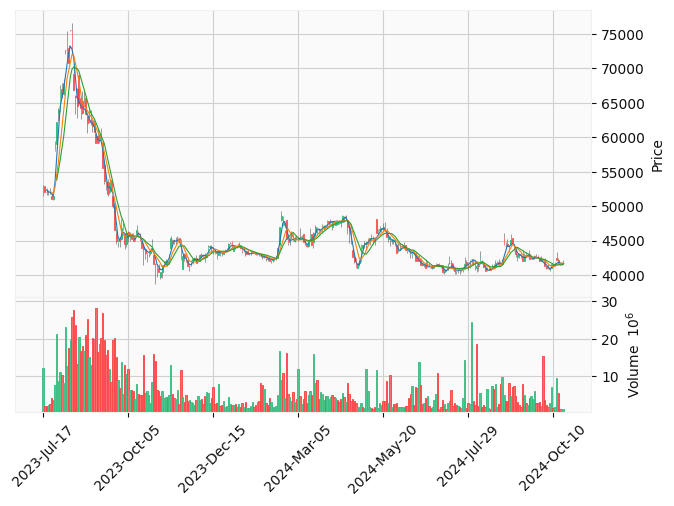

In [4]:
# draw general candle plots
mpf.plot(df_data, type = 'candle', volume =True, style = 'yahoo', mav = (3,6,9))


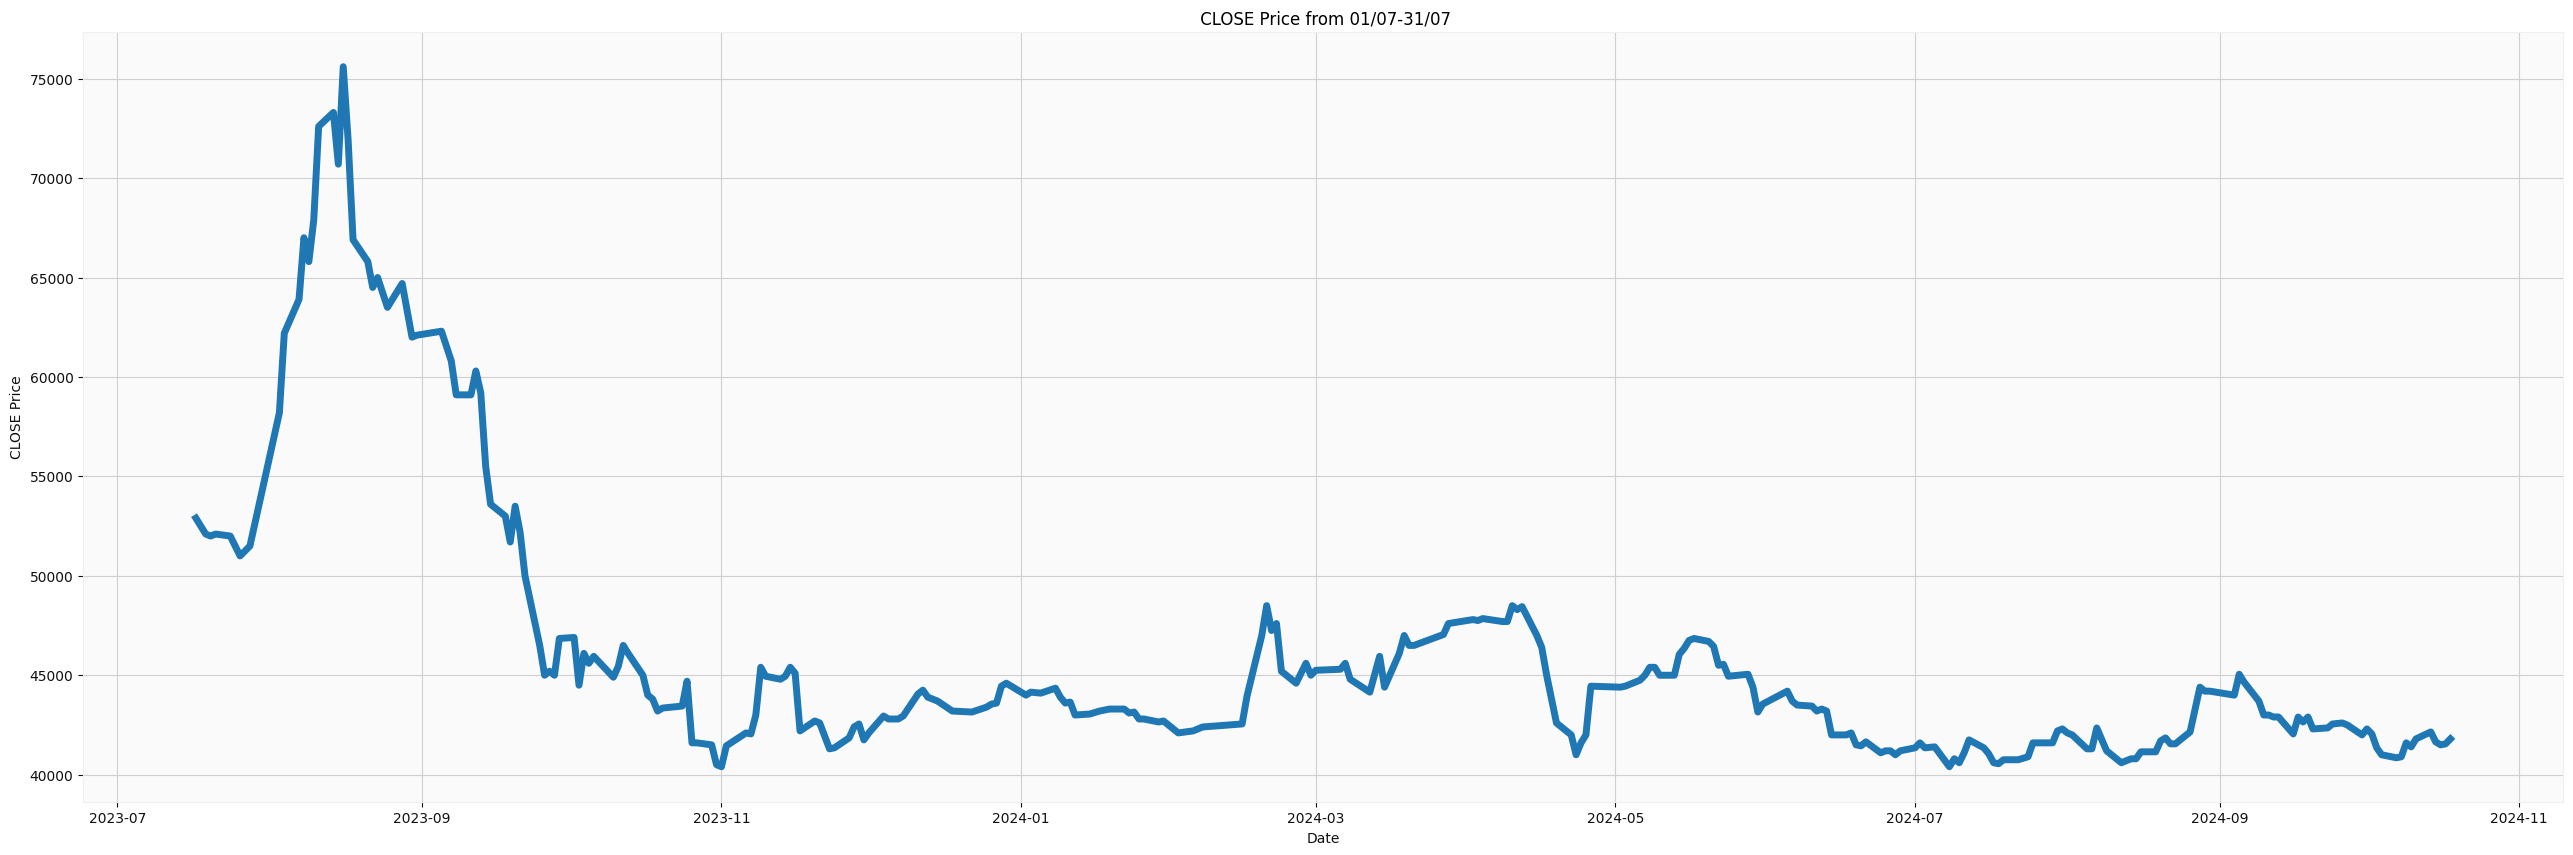

In [5]:
# draw line chart using seaborn
fig, ax = plt.subplots(figsize=(32, 10), dpi=100)
ax.set_title(" CLOSE Price from 01/07-31/07")
ax.set_xlabel("Date")
ax.set_ylabel("CLOSE Price")
sns.lineplot(data=df_data["Close"], palette= ['red'], linewidth=5, legend=True )
plt.show()


### ***BUILD MODEL***

In [6]:
X = df_data.values
y = df_data['Close']

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(y.values.reshape(-1,1)) 


In [8]:
import math

In [9]:
dataset = y.values

In [10]:
training_data_len  = math.ceil(len(dataset)*.8)
training_data_len

246

In [11]:
prediction_days = 60
future = 30
# give detail of the chart (split data into x_train, y_train) 
x_train = []
y_train =[]

for i in range(prediction_days, len(scaled_data)-future):
    x_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i+future,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [12]:
# create model LSTM
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0,2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0,2))
model.add(LSTM(units = 50))
model.add(Dropout(0,2))
model.add(Dense(units = 1))
#compiling and training 
model.compile(optimizer = 'adam', loss ='mean_squared_error')
# epochs: How many times the data is trained in network
# batch_size: The number of training samples in the network at once 
model.fit(x_train, y_train, epochs  = 25, batch_size = 30)

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0058
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0036
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0034
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0034
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0032
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0034
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0032
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0032
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0032
Epoch 10/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0031
Epoch 11/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0031
Epoch 12/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0033
Epoch 13/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0030
Epoch 14/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0031
Epoch 15/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0029
Epoch 16/25
8/8 ━━━━━━━━━━━━━━━━━━

In [13]:
test_data = scaled_data[training_data_len - prediction_days: , :]

In [14]:
X_test = []
y_test = scaled_data[training_data_len:,:]
for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i,0])

In [15]:
X_test = np.array(X_test)

In [16]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [17]:
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


### ***RESULT***

In [18]:
train = df_data[:training_data_len]
valid = df_data[training_data_len:]
valid['Prediction'] = predicted_price

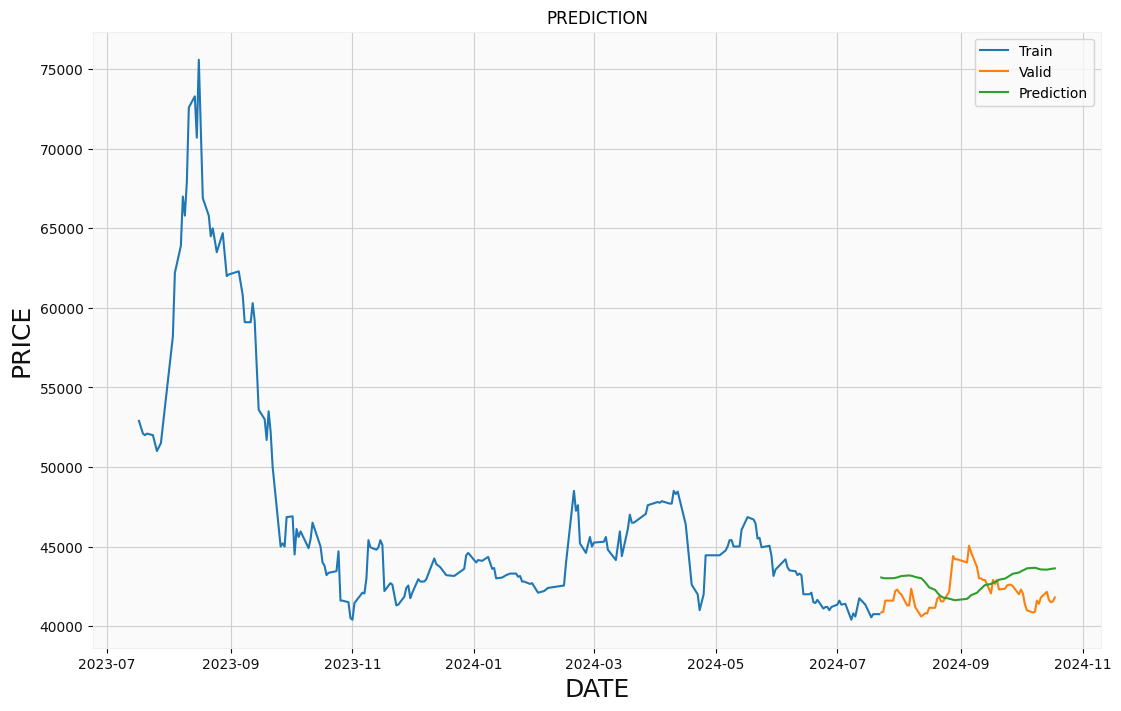

In [19]:
plt.figure(figsize = (13,8))
plt.title('PREDICTION')
plt.xlabel('DATE', fontsize  = 18)
plt.ylabel('PRICE',fontsize  = 18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Prediction'])
plt.legend(['Train', 'Valid', 'Prediction'], loc = 'upper right')
plt.show()



In [20]:
result = valid[['Close','Prediction']]
result

,Close,Prediction
Date,,
2024-07-23 00:00:00+07:00,40850.0,43055.144531
2024-07-24 00:00:00+07:00,40900.0,43017.437500
2024-07-25 00:00:00+07:00,41600.0,43005.671875
2024-07-26 00:00:00+07:00,41600.0,43003.199219
2024-07-29 00:00:00+07:00,41600.0,43011.953125
2024-07-30 00:00:00+07:00,42200.0,43029.664062
2024-07-31 00:00:00+07:00,42300.0,43059.960938
2024-08-01 00:00:00+07:00,42100.0,43101.140625
2024-08-02 00:00:00+07:00,42000.0,43142.304688


In [21]:
# check acuracy 
def Accuracy_result(actual_price, prediction):
    result = np.mean(100 * (np.abs(actual_price - prediction) / prediction))
    return(100-result)
print("The accuracy for this model is", str(Accuracy_result(valid['Close'][0],predicted_price[0])), "%")

The accuracy for this model is 94.87832546234131 %


In [24]:
jb.dump(model,'model.pkl')
jb.dump(scaler,'scaler.pkl')

['scaler.pkl']